In [3]:
%%capture
!pip install nibabel
!pip install polars

In [4]:
from google.colab import drive
drive.mount('/content/drive')
import os
import sys
import numpy as np
import nibabel as nib  # remember to install nibabel library in the notebook
from skimage.transform import resize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import re
import glob
import polars as pr

Mounted at /content/drive


In [5]:
# path to annotation definition
wholegland_del_path = '/content/drive/My Drive/ABELE_prostate/PICAI_original/anatomical_delineations/whole_gland/AI//Guerbet23/'
original_adc_ann_path = '/content/drive/My Drive/ABELE_prostate/PICAI_original/csPCa_lesion_delineations/human_expert/original/'
resampled_t2w_ann_path = '/content/drive/My Drive/ABELE_prostate/PICAI_original/csPCa_lesion_delineations/human_expert/resampled/'
lesion_path =  '/content/drive/My Drive/ABELE_prostate/PICAI_original/csPCa_lesion_delineations/AI/Bosma22a'

# Define the path to the input dataset and the output directory and chekpoint file path:
input_path = '/content/drive/My Drive/ABELE_prostate/PICAI_original/Dataset/'
output_path = '/content/drive/My Drive/ABELE_prostate/claudio/black_box/data/PICAI_crop/prostate_centered/'

# path to metadata csv
csv = '/content/drive/My Drive/ABELE_prostate/PICAI_original/clinical_information/marksheet.csv'

In [ ]:
df = pr.read_csv(csv)

In [6]:
def get_crop_coordinates(delineation_path, num_slices):
    try:
        img = nib.load(delineation_path)
        img_fdata = img.get_fdata()
    except Exception as e:
        print(f"Error loading NIfTI file: {delineation_path}")
        print(f"Error message: {str(e)}")
        return [], []

    img_resized = resize(img_fdata, (384, 384), preserve_range=True)
    cumsum_slices = np.sum(np.sum(img_resized, axis=0), axis=0)

    # Get indices of top slices based on overall density
    top_slice_indices = np.argsort(cumsum_slices)[-num_slices:][::-1]

    # Calculate average cumulative sum density
    avg_density = np.mean(cumsum_slices)

    return top_slice_indices.tolist(), cumsum_slices, avg_density

In [7]:
def process_patient_data(data_path, num_slices,
                         min_density, threshold):
    data_dict = {}
    counter = 0
    density_counter = 0
    tot_avg_density = 0

    for i, patient_file in enumerate(sorted(os.listdir(data_path))):

        if threshold is not None and i >= (threshold - 1):
            break

        if patient_file.endswith('.md'):
            continue

        patient_path = os.path.join(data_path, patient_file)
        patient_id = patient_file.split('.')[0]
        top_slices, cumsum_slices, avg_density = get_crop_coordinates(patient_path, num_slices)
        counter += 1

        print(f'patient num {counter} ({patient_id}) average density: {avg_density}')

        if np.sum(cumsum_slices) > min_density:
            tot_avg_density += avg_density
            density_counter += 1
            if patient_id not in data_dict:
                data_dict[patient_id] = []

            data_dict[patient_id].extend(top_slices)

    print(f'total avg density {tot_avg_density/density_counter:.2f} over {density_counter} patients')
    return data_dict

In [ ]:
num_slices = 15
threshold = None
min_density = 1

# Process lesion data
lesion_dict = process_patient_data(lesion_path, num_slices,
                                   min_density=min_density,
                                   threshold=threshold)

patient num 1 (10000_1000000) average density: 0.0
patient num 2 (10001_1000001) average density: 0.0
patient num 3 (10002_1000002) average density: 0.0
patient num 4 (10003_1000003) average density: 0.0
patient num 5 (10004_1000004) average density: 0.0
patient num 6 (10005_1000005) average density: 28.210526315789473
patient num 7 (10006_1000006) average density: 0.0
patient num 8 (10007_1000007) average density: 0.0
patient num 9 (10008_1000008) average density: 114.04761904761905
patient num 10 (10009_1000009) average density: 0.0
patient num 11 (10010_1000010) average density: 0.0
patient num 12 (10011_1000011) average density: 0.0
patient num 13 (10012_1000012) average density: 62.78260869565217
patient num 14 (10013_1000013) average density: 30.375
patient num 15 (10014_1000014) average density: 0.0
patient num 16 (10015_1000015) average density: 0.0
patient num 17 (10016_1000016) average density: 0.0
patient num 18 (10017_1000017) average density: 0.0
patient num 19 (10018_1000

In [ ]:
# Plot the average density distribution
plt.hist(avg_densities, bins=20, edgecolor='black')
plt.title('Average Density Distribution')
plt.xlabel('Average Density')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Process whole gland delineation data
delineation_dict = process_patient_data(wholegland_del_path,
                                        num_slices, min_density=0,
                                        threshold=threshold)

patient num 1(10000_1000000) average density: 1580.2932188584832
patient num 2(10001_1000001) average density: 4681.746815852448
patient num 3(10002_1000002) average density: 4275.227272727273
patient num 4(10003_1000003) average density: 4187.304347826087
patient num 5(10004_1000004) average density: 3237.8230808773183
patient num 6(10005_1000005) average density: 4031.4736842105262
patient num 7(10006_1000006) average density: 2203.3809523809523
patient num 8(10007_1000007) average density: 2168.337852856657
patient num 9(10008_1000008) average density: 3390.5238095238096
patient num 10(10009_1000009) average density: 1390.3233673017098
patient num 11(10010_1000010) average density: 2731.0073238570208
patient num 12(10011_1000011) average density: 1727.6296296296296
patient num 13(10012_1000012) average density: 4217.826086956522
patient num 14(10013_1000013) average density: 3191.4166666666665
patient num 15(10014_1000014) average density: 3505.321832548921
patient num 16(10015_1000

In [ ]:
# Plot the average density distribution
plt.hist(avg_densities, bins=20, edgecolor='black')
plt.title('Average Density Distribution')
plt.xlabel('Average Density')
plt.ylabel('Frequency')
plt.show()

In [ ]:
common_ids = sorted(set(lesion_dict.keys()).intersection(delineation_dict.keys()))
tot_commons = 0
tot_slices = 0

for key in common_ids:
    lesion_slices = sorted(lesion_dict[key])
    delineation_slices = sorted(delineation_dict[key])
    common_slices = sorted(set(lesion_slices).intersection(delineation_slices))
    tot_commons += len(common_slices)
    tot_slices += len(delineation_slices)

    print(f'patient_id {key}:')
    print(f'\tlesion slice indices {lesion_slices}')
    print(f'\tdelineation slice indices {delineation_slices}')
    print(f'\tcommon slices {common_slices}')
    print(f'\tnum of common slices {len(common_slices)}\n')

print(f'\ntotal patient files with common slices: {len(common_ids)}\
 out of {len(delineation_dict.keys())} ({(len(common_ids)/len(delineation_dict.keys())):.1%})')

print(f'total common slices {tot_commons} out of {tot_slices}\
 ({tot_commons/tot_slices:.2%})')

Streaming output truncated to the last 5000 lines.
	lesion slice indices [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 21, 22]
	delineation slice indices [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
	common slices [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
	num of common slices 11

patient_id 10652_1000668:
	lesion slice indices [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 17, 18]
	delineation slice indices [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
	common slices [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
	num of common slices 12

patient_id 10653_1000669:
	lesion slice indices [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 19, 20]
	delineation slice indices [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
	common slices [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
	num of common slices 13

patient_id 10654_1000670:
	lesion slice indices [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 21, 22]
	delineation slice indices [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
	commo

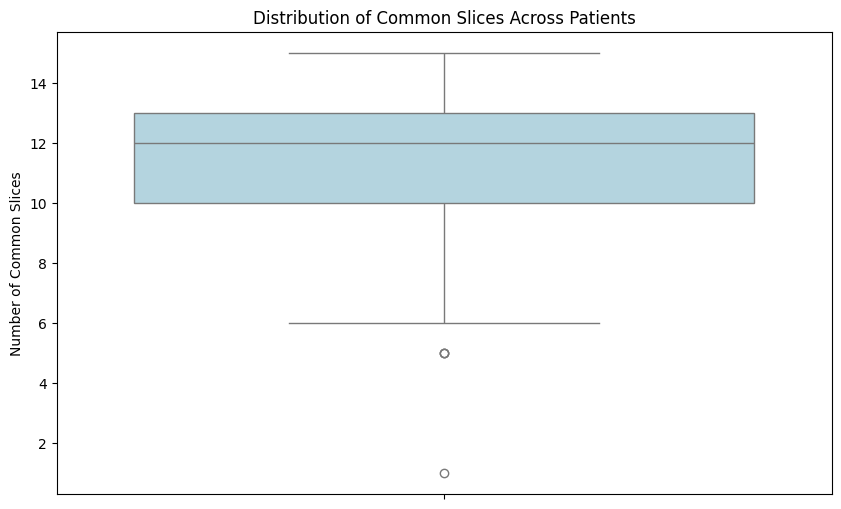

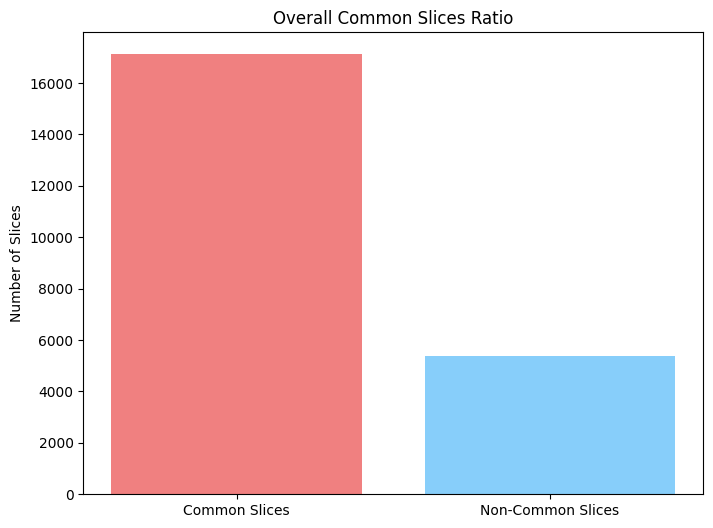

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have these variables defined
# common_ids, tot_commons, tot_slices

# Create a list of the number of common slices for each patient
common_slices_per_patient = [len(set(lesion_dict[key]).intersection(delineation_dict[key])) for key in common_ids]

# Plotting a box plot to show the distribution of common slices
plt.figure(figsize=(10, 6))
sns.boxplot(y=common_slices_per_patient, color='lightblue')
plt.ylabel('Number of Common Slices')
plt.title('Distribution of Common Slices Across Patients')
plt.show()

# Plotting a simple bar chart for the overall common slices ratio
plt.figure(figsize=(8, 6))
plt.bar(['Common Slices', 'Non-Common Slices'], [tot_commons, tot_slices - tot_commons], color=['lightcoral', 'lightskyblue'])
plt.ylabel('Number of Slices')
plt.title('Overall Common Slices Ratio')
plt.show()